# Data sources for MLlib

In [1]:
import os
import sys
# Here you need to have same Python version on your local machine adn on worker node i.e. EC2. here both should have python3.
os.environ["PYSPARK_PYTHON"] = "/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [2]:
# Run this cell if you are using sklearn for the first time
# ! pip3 install sklearn --userb

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Mllib- Machine Learning Models').getOrCreate()

In [3]:
# From Pandas to Spark DataFrames

from sklearn.datasets import load_boston
import pandas as pd
boston = load_boston()

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['price'] = boston.target

In [5]:
sdf = spark.createDataFrame(df)
sdf.show(truncate=False)

+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+
|CRIM   |ZN  |INDUS|CHAS|NOX  |RM   |AGE  |DIS   |RAD|TAX  |PTRATIO|B     |LSTAT|price|
+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+
|0.00632|18.0|2.31 |0.0 |0.538|6.575|65.2 |4.09  |1.0|296.0|15.3   |396.9 |4.98 |24.0 |
|0.02731|0.0 |7.07 |0.0 |0.469|6.421|78.9 |4.9671|2.0|242.0|17.8   |396.9 |9.14 |21.6 |
|0.02729|0.0 |7.07 |0.0 |0.469|7.185|61.1 |4.9671|2.0|242.0|17.8   |392.83|4.03 |34.7 |
|0.03237|0.0 |2.18 |0.0 |0.458|6.998|45.8 |6.0622|3.0|222.0|18.7   |394.63|2.94 |33.4 |
|0.06905|0.0 |2.18 |0.0 |0.458|7.147|54.2 |6.0622|3.0|222.0|18.7   |396.9 |5.33 |36.2 |
|0.02985|0.0 |2.18 |0.0 |0.458|6.43 |58.7 |6.0622|3.0|222.0|18.7   |394.12|5.21 |28.7 |
|0.08829|12.5|7.87 |0.0 |0.524|6.012|66.6 |5.5605|5.0|311.0|15.2   |395.6 |12.43|22.9 |
|0.14455|12.5|7.87 |0.0 |0.524|6.172|96.1 |5.9505|5.0|311.0|15.2   |396.9 |19.15|27.1 |
|0.21124|12.5|7.87 |0.0 |0.524|5

# Linear Regression with MLlib

In [6]:
from pyspark.ml.regression import LinearRegression

In [7]:
lr = LinearRegression()
lr.fit(sdf)

IllegalArgumentException: 'Field "features" does not exist.\nAvailable fields: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT, price'

## What went wrong?

In [8]:
from pyspark.ml.feature import VectorAssembler

In [9]:
assembler = VectorAssembler(inputCols=[c for c in sdf.columns if c != 'price'],
                            outputCol='features')
dataset = assembler.transform(sdf)

In [10]:
dataset.show()

+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+--------------------+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM|  AGE|   DIS|RAD|  TAX|PTRATIO|     B|LSTAT|price|            features|
+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+--------------------+
|0.00632|18.0| 2.31| 0.0|0.538|6.575| 65.2|  4.09|1.0|296.0|   15.3| 396.9| 4.98| 24.0|[0.00632,18.0,2.3...|
|0.02731| 0.0| 7.07| 0.0|0.469|6.421| 78.9|4.9671|2.0|242.0|   17.8| 396.9| 9.14| 21.6|[0.02731,0.0,7.07...|
|0.02729| 0.0| 7.07| 0.0|0.469|7.185| 61.1|4.9671|2.0|242.0|   17.8|392.83| 4.03| 34.7|[0.02729,0.0,7.07...|
|0.03237| 0.0| 2.18| 0.0|0.458|6.998| 45.8|6.0622|3.0|222.0|   18.7|394.63| 2.94| 33.4|[0.03237,0.0,2.18...|
|0.06905| 0.0| 2.18| 0.0|0.458|7.147| 54.2|6.0622|3.0|222.0|   18.7| 396.9| 5.33| 36.2|[0.06905,0.0,2.18...|
|0.02985| 0.0| 2.18| 0.0|0.458| 6.43| 58.7|6.0622|3.0|222.0|   18.7|394.12| 5.21| 28.7|[0.02985,0.0,2.18...|
|0.08829|12.5| 7.87

In [11]:
lr = LinearRegression(featuresCol='features', labelCol='price')
model = lr.fit(dataset)

In [12]:
summary = model.evaluate(dataset)
print(summary.r2)

0.7406426641094093


## Other regression methods

In [13]:
from pyspark.ml.regression import DecisionTreeRegressor

In [14]:
dtr = DecisionTreeRegressor(featuresCol='features', labelCol='price')
model = dtr.fit(dataset)

In [15]:
summary = model.evaluate(dataset)
print(summary.r2)

AttributeError: 'DecisionTreeRegressionModel' object has no attribute 'evaluate'

### Different algorithms may have different interfaces!

In [16]:
output = model.transform(dataset)
output.select('prediction').show()

+------------------+
|        prediction|
+------------------+
| 26.11515151515151|
| 21.04507042253521|
|34.864705882352936|
|34.864705882352936|
|34.864705882352936|
|24.206976744186047|
| 21.04507042253521|
|19.549999999999997|
| 16.20724637681159|
|19.549999999999997|
| 16.20724637681159|
| 21.04507042253521|
|21.981818181818184|
| 21.04507042253521|
| 21.04507042253521|
| 21.04507042253521|
|24.206976744186047|
| 16.20724637681159|
| 21.04507042253521|
| 21.04507042253521|
+------------------+
only showing top 20 rows



In [17]:
output.select('price').show()

+-----+
|price|
+-----+
| 24.0|
| 21.6|
| 34.7|
| 33.4|
| 36.2|
| 28.7|
| 22.9|
| 27.1|
| 16.5|
| 18.9|
| 15.0|
| 18.9|
| 21.7|
| 20.4|
| 18.2|
| 19.9|
| 23.1|
| 17.5|
| 20.2|
| 18.2|
+-----+
only showing top 20 rows



## How do we evaluate this?

In [18]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction', metricName='r2')
evaluator.evaluate(output)

0.9098424850624001

## Exercise: Use `RandomForestRegressor` (provided below) and report the R2 score

In [25]:
from pyspark.ml.regression import RandomForestRegressor

In [26]:
# enter code here

# Classification with MLlib

In [27]:
from pyspark.ml.classification import LogisticRegression

In [39]:
df = spark.read.format("csv")\
    .option("inferSchema", True)\
    .option("header", True)\
    .load("iris.csv")
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_widthCm: double (nullable = true)
 |-- species: string (nullable = true)



In [40]:
df.show(5)

+------------+-----------+------------+-------------+-----------+
|sepal_length|sepal_width|petal_length|petal_widthCm|    species|
+------------+-----------+------------+-------------+-----------+
|         5.1|        3.5|         1.4|          0.2|Iris-setosa|
|         4.9|        3.0|         1.4|          0.2|Iris-setosa|
|         4.7|        3.2|         1.3|          0.2|Iris-setosa|
|         4.6|        3.1|         1.5|          0.2|Iris-setosa|
|         5.0|        3.6|         1.4|          0.2|Iris-setosa|
+------------+-----------+------------+-------------+-----------+
only showing top 5 rows



In [41]:
assembler = VectorAssembler(inputCols=[c for c in df.columns if c != 'species'],
                            outputCol='features')

In [42]:
iris = assembler.transform(df)

In [43]:
lr = LogisticRegression(featuresCol='features', labelCol='species')
model = lr.fit(iris)

IllegalArgumentException: 'requirement failed: Column species must be of type numeric but was actually of type string.'

## What went wrong?

In [44]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='species', outputCol='speciesIndex')

iris = indexer.fit(df).transform(df)

iris.sample(fraction=0.1).show()

+------------+-----------+------------+-------------+---------------+------------+
|sepal_length|sepal_width|petal_length|petal_widthCm|        species|speciesIndex|
+------------+-----------+------------+-------------+---------------+------------+
|         5.1|        3.7|         1.5|          0.4|    Iris-setosa|         0.0|
|         5.1|        3.3|         1.7|          0.5|    Iris-setosa|         0.0|
|         5.0|        3.5|         1.3|          0.3|    Iris-setosa|         0.0|
|         4.6|        3.2|         1.4|          0.2|    Iris-setosa|         0.0|
|         5.7|        2.8|         4.1|          1.3|Iris-versicolor|         1.0|
|         5.6|        2.8|         4.9|          2.0| Iris-virginica|         2.0|
|         7.7|        3.0|         6.1|          2.3| Iris-virginica|         2.0|
+------------+-----------+------------+-------------+---------------+------------+



In [45]:
assembler = VectorAssembler(inputCols=[c for c in df.columns if not c.startswith('species')],
                            outputCol='features')
dataset = assembler.transform(iris)

In [46]:
dataset.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_widthCm: double (nullable = true)
 |-- species: string (nullable = true)
 |-- speciesIndex: double (nullable = false)
 |-- features: vector (nullable = true)



In [47]:
lr = LogisticRegression(featuresCol='features', labelCol='speciesIndex')
model = lr.fit(dataset)

In [48]:
summary = model.evaluate(dataset)

In [49]:
summary.accuracy

0.9866666666666667

## That's too convenient

In [50]:
trainData, testData = dataset.randomSplit([0.7, 0.3])

In [51]:
model = lr.fit(trainData)
summary = model.evaluate(testData)

In [52]:
summary.accuracy

0.9333333333333333

## Exercise: Use the NaiveBayes classifier on the Iris dataset
### Check the accuracy for a 60-40 train / test split.
### Hint: Use the `MulticlassClassificationEvaluator`

In [53]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

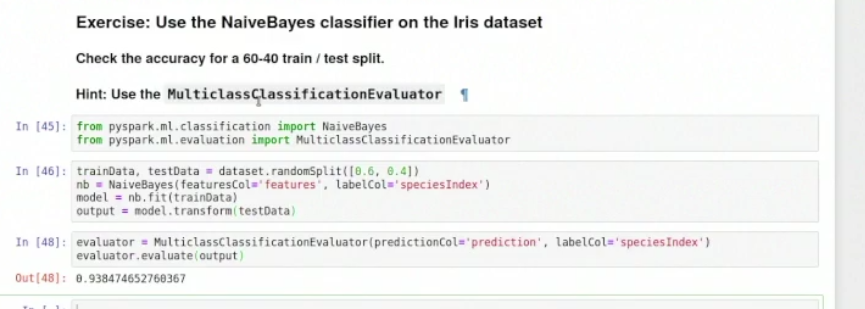